In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def vander_matrix(X, K):
    N = len(X)
    vander = np.zeros((N, K))
    for i in range(N):
        for j in range(K):
            vander[i, j] = X[i] ** j

    return vander


def generate_test_problem_dataset(K, N, a, b, variance):
    theta_true = np.ones((K,))

    X = np.random.uniform(a, b, N)

    Phi_X = vander_matrix(X, K)
    Y = Phi_X @ theta_true + np.random.normal(0, variance, N)

    return X, Y, theta_true


def shuffle_dataset(X, Y):
    indices = np.array(range(len(X)))
    np.random.shuffle(indices)

    return X[indices], Y[indices]


def split_dataset(X, Y, n_train):
    indices = np.array(range(len(X)))

    train_indices = indices[:n_train]
    test_indices = indices[n_train:]

    Xtrain = X[train_indices]
    Xtest = X[test_indices]

    Ytrain = Y[train_indices]
    Ytest = Y[test_indices]

    return Xtrain, Ytrain, Xtest, Ytest


def shuffle_and_split_dataset(X, Y, n_train):
    X, Y = shuffle_dataset(X, Y)

    return split_dataset(X, Y, n_train)




In [3]:
K = 4
a = 0
b = 1
N = 200
N_test = int(0.6 * N)
variance = 0.5
mean = 1

X, Y, theta_true = generate_test_problem_dataset(K, N=N, a=a, b=b, variance=variance)
Xtrain, Ytrain, Xtest, Ytest = shuffle_and_split_dataset(X, Y, N_test)

In [4]:
def gradient_descent(grad_f, x_0, k_max, tol_f, tol_x, alpha=1e-4):
    x_k = x_0

    k = 0
    while k < k_max:
        k = k + 1
        x_prev = x_k
        x_k = x_k - alpha * grad_f(x_k)

        if np.linalg.norm(grad_f(x_k)) < tol_f * np.linalg.norm(grad_f(x_0)):
            break
        if np.linalg.norm(x_k - x_prev) < tol_x:
            break

    return x_k


def stochastic_gradient_descent(grad_l, w_0, data, batch_size, n_epochs, alpha=0.1):
    w_k = w_0

    X, Y = data
    N = X.shape[0]

    if N % batch_size != 0:
        raise Exception(f"Batch size must divide the dataset size. {N=} {batch_size=}")

    batch_count = N // batch_size

    for epoch in range(n_epochs):
        X_copy = np.copy(X)
        Y_copy = np.copy(Y)

        indices = np.arange(N)
        np.random.shuffle(indices)

        for i in range(batch_count):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]

            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]

            gradient = grad_l(w_k, X_batch, Y_batch)
            w_k = w_k - alpha * gradient

        X = X_copy
        Y = Y_copy

    return w_k

In [5]:
def mle_grad_func(theta, X, Y, K):
    A = vander_matrix(X, K)
    return A.T @ (A @ theta - Y)


def mle_gradient_descent(training_data, K):
    X, Y = training_data

    def _grad(theta):
        K = len(theta)
        return mle_grad_func(theta, X, Y, K)

    return gradient_descent(grad_f=_grad, x_0=np.zeros((K,)), k_max=100, tol_x=1 - 6, tol_f=1 - 6, alpha=1e-4)


def mle_stochastic_gradient_descent(training_data, K):
    def _grad(theta, X, Y):
        K = len(theta)
        return mle_grad_func(theta, X, Y, K)

    return stochastic_gradient_descent(grad_l=_grad, w_0=np.zeros((K,)), data=training_data, batch_size=20, n_epochs=20,
                                       alpha=1e-2)


def mle_normal_equation(training_data, K):
    (X, Y) = training_data

    Phi_x = vander_matrix(X, K)

    A = Phi_x.T @ Phi_x
    b = Phi_x.T @ Y

    return np.linalg.solve(A, b)


def MLE(training_data, K, optimization="normal_equation"):
    optimization_func = None

    if optimization == "gradient_descent":
        optimization_func = mle_gradient_descent
    if optimization == "normal_equation":
        optimization_func = mle_normal_equation
    if optimization == "sgd":
        optimization_func = mle_stochastic_gradient_descent

    return optimization_func(training_data, K)



In [6]:
def polynomial_regressor(theta):
    K = len(theta)

    def _polynomial_regressor(x):
        return vander_matrix(x, K) @ theta

    return _polynomial_regressor


def average_absolute_error(theta, test_set):
    Xtest, Ytest = test_set
    N = len(Ytest)

    regressor = polynomial_regressor(theta)

    return (1 / N) * (np.linalg.norm(regressor(Xtest) - Ytest) ** 2)

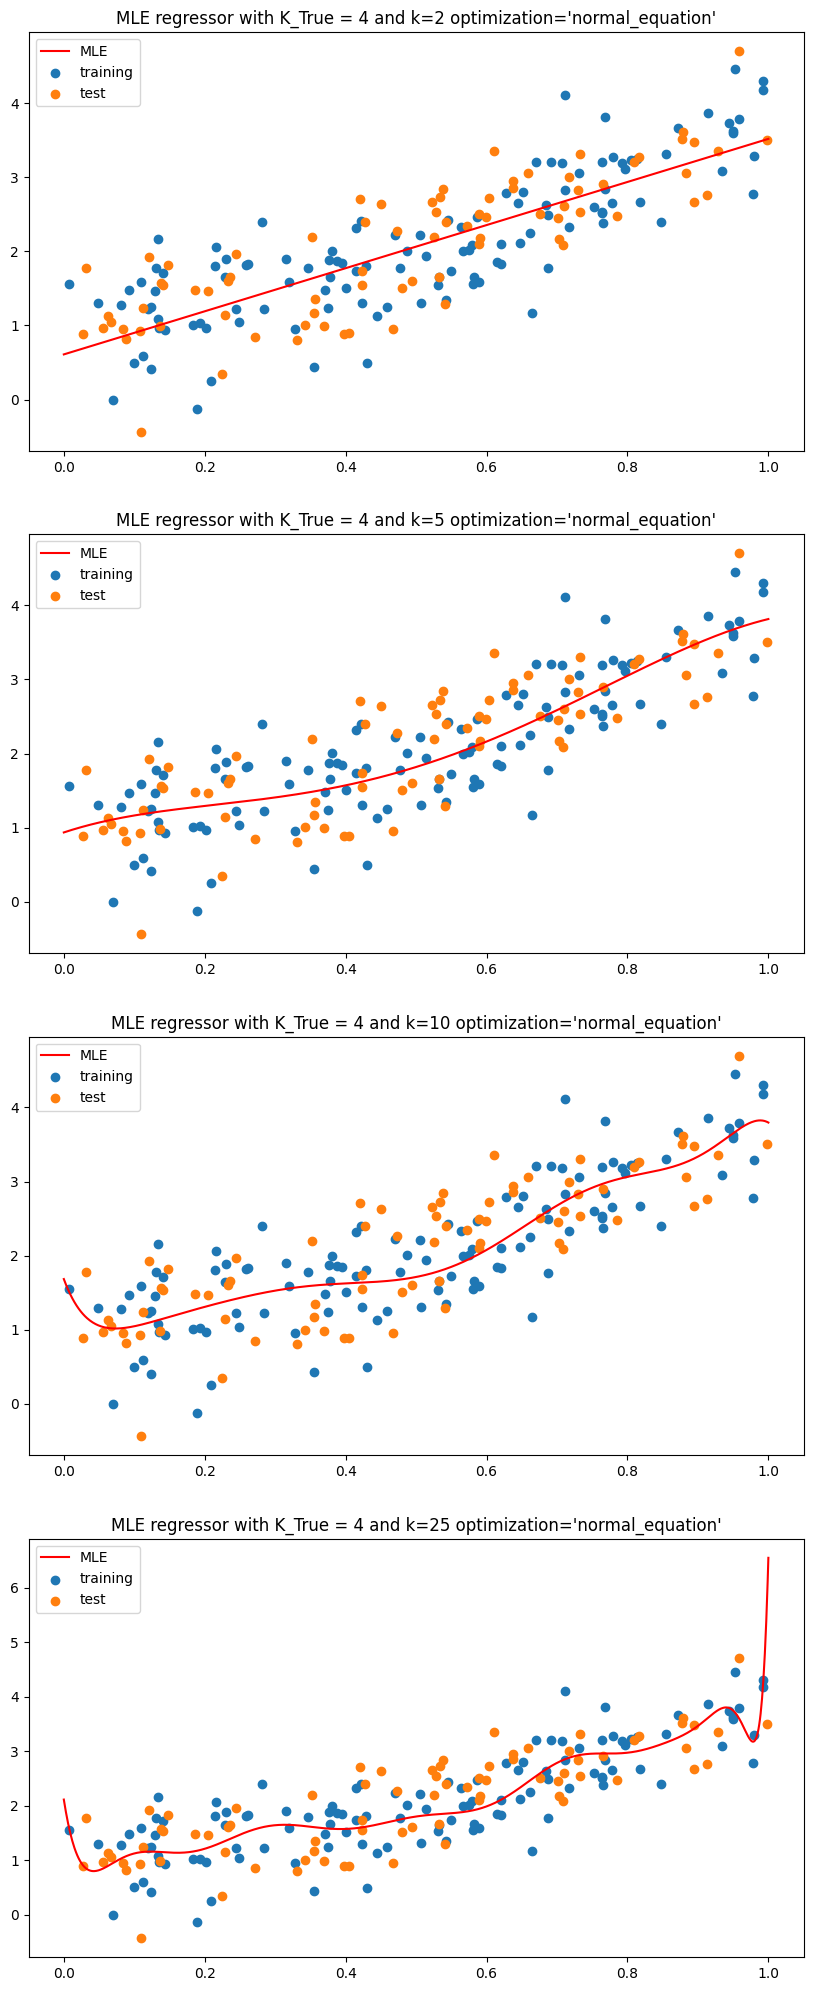

In [7]:
def visualize_regressor(regressor, Dtrain, Dtest, k, title="", ax=None):
    interval = np.linspace(a, b, 1000)
    y = regressor(interval)

    if not ax:
        plt.plot(interval, y, label="MLE", color="red")
        plt.scatter(Dtrain[0], Dtrain[1], label="training")
        plt.scatter(Dtest[0], Dtest[1], label="test")
        plt.title(title)
        plt.legend()
    else:
        ax.plot(interval, y, label="MLE", color="red")
        ax.scatter(Dtrain[0], Dtrain[1], label="training")
        ax.scatter(Dtest[0], Dtest[1], label="test")
        ax.set_title(title)
        ax.legend()

def test_mle_regressor_and_plot(k,ax, optimization="normal_equation"):
    theta_star = MLE((Xtrain, Ytrain), k, optimization=optimization)

    regressor = polynomial_regressor(theta_star)
    visualize_regressor(regressor, (Xtrain, Ytrain), (Xtest, Ytest), k=k, title=f"MLE regressor with K_True = {K} and {k=} {optimization=}", ax=ax)


def mle_regressor_plot_for_different_k(ks):
    fig, ax = plt.subplots(len(ks), figsize=(10, 25))
    for i, k in enumerate(ks):
        test_mle_regressor_and_plot(k, ax[i], optimization="normal_equation")


mle_regressor_plot_for_different_k(ks=[2, 5, 10, 25])

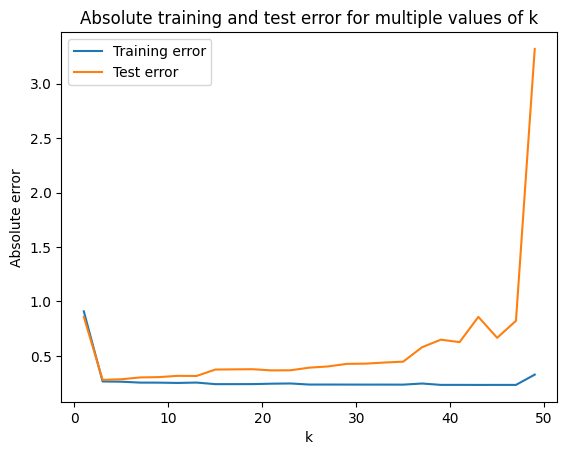

In [8]:
def mle_error_plotting(ks):
    train_errors = []
    test_errors = []

    for k in ks:
        theta_star = MLE((Xtrain, Ytrain), k, optimization="normal_equation")

        train_error = average_absolute_error(theta_star, (Xtrain, Ytrain))
        test_error = average_absolute_error(theta_star, (Xtest, Ytest))

        train_errors.append(train_error)
        test_errors.append(test_error)

    plt.plot(ks, train_errors, label="Training error")
    plt.plot(ks, test_errors, label="Test error")
    plt.xlabel("k")
    plt.ylabel("Absolute error")
    plt.title("Absolute training and test error for multiple values of k")
    plt.legend()


mle_error_plotting(ks=range(1, 50,2))


In [9]:
def map_grad_func(theta, X, Y, K, lambda_):
    return mle_grad_func(theta, X, Y, K) + 2 * lambda_ * theta


def map_gradient_descent(training_data, K, lambda_):
    X, Y = training_data

    def _grad(theta):
        K = len(theta)
        return map_grad_func(theta, X, Y, K, lambda_)

    return gradient_descent(grad_f=_grad, x_0=np.zeros((K,)), k_max=100, tol_x=1 - 6, tol_f=1 - 6, alpha=1e-4)

def map_stochastic_gradient_descent(training_data, K, lambda_):
    def _grad(theta, X, Y):
        K = len(theta)
        return map_grad_func(theta, X, Y, K, lambda_)

    return stochastic_gradient_descent(grad_l=_grad, w_0=np.zeros((K,)), data=training_data, batch_size=20, n_epochs=20,
                                       alpha=1e-2)

def map_normal_equation(training_data, K, lambda_):
    (X, Y) = training_data

    Phi_x = vander_matrix(X, K)

    A = Phi_x.T @ Phi_x + (lambda_ * np.eye(K))
    b = Phi_x.T @ Y

    return np.linalg.solve(A, b)


def MAP(training_data, K, lambda_, optimization="normal_equation"):
    optimization_func = None

    if optimization == "gradient_descent":
        optimization_func = map_gradient_descent
    if optimization == "normal_equation":
        optimization_func = map_normal_equation
    if optimization == "sgd":
        optimization_func = map_stochastic_gradient_descent

    return optimization_func(training_data, K, lambda_)


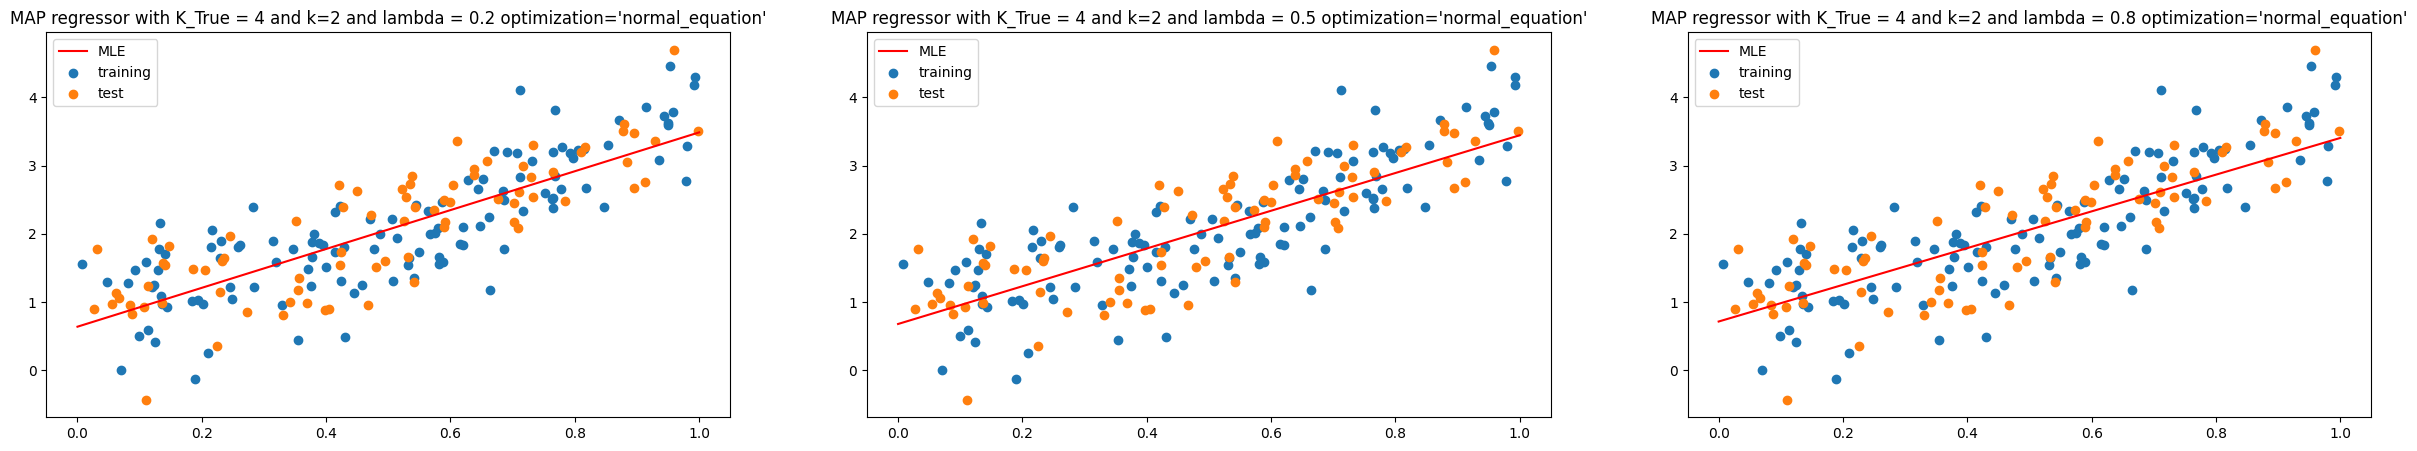

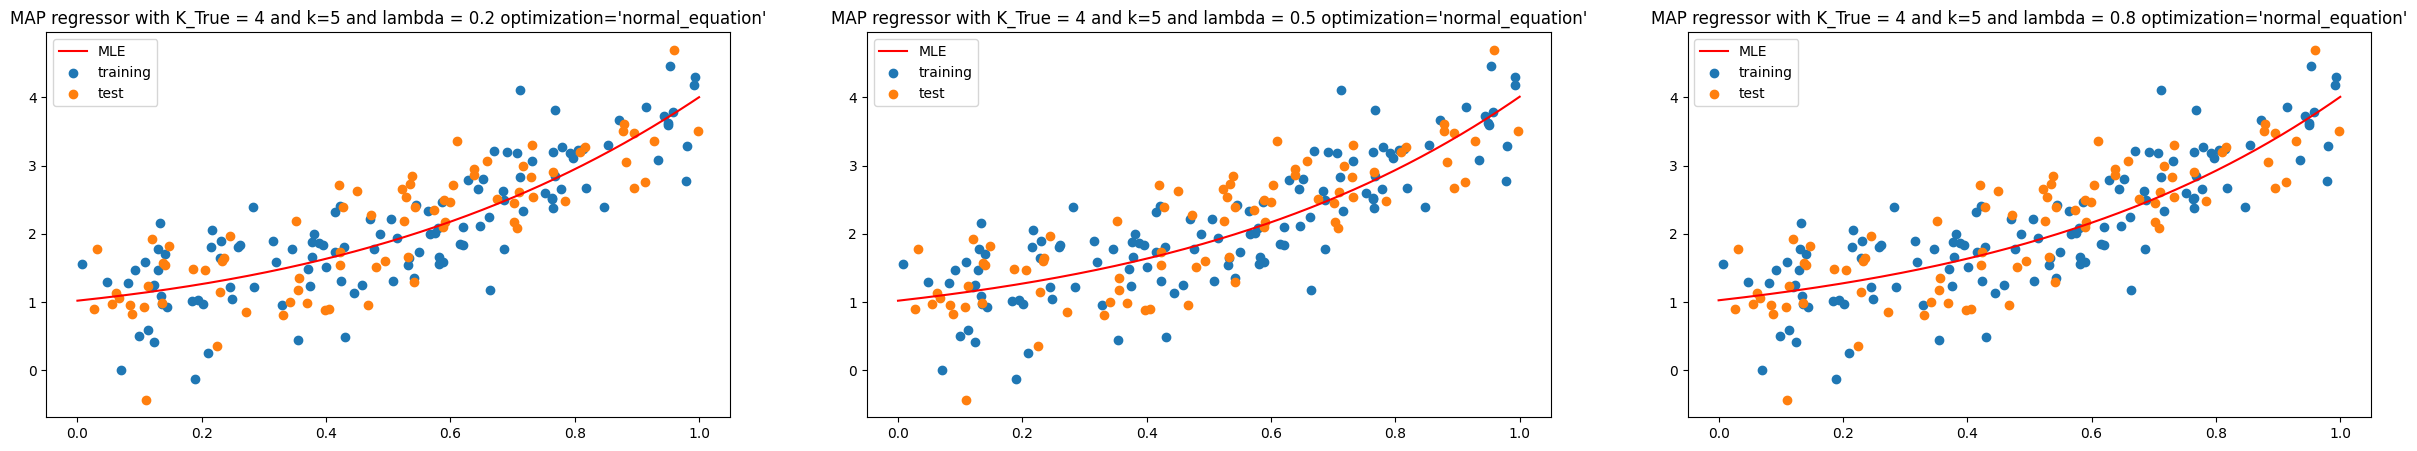

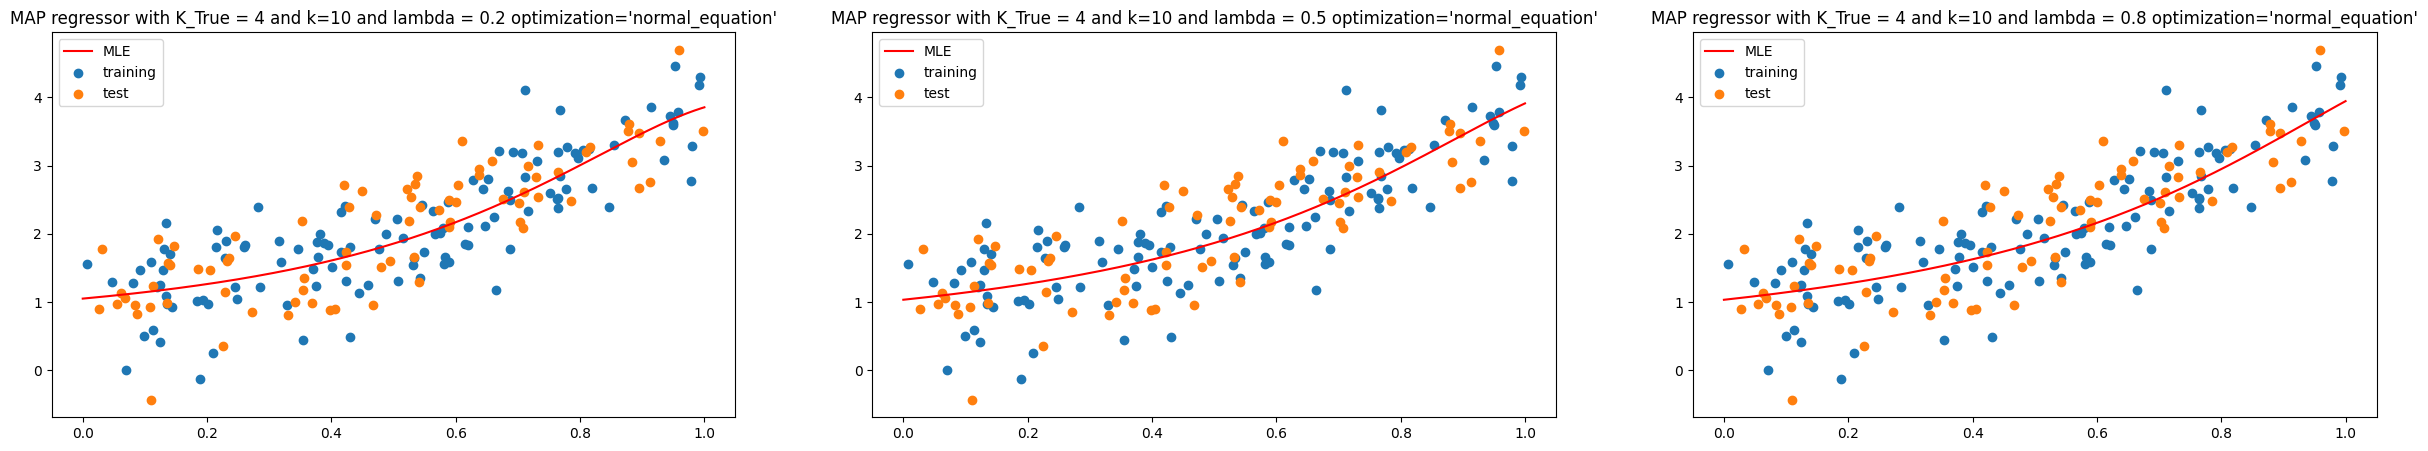

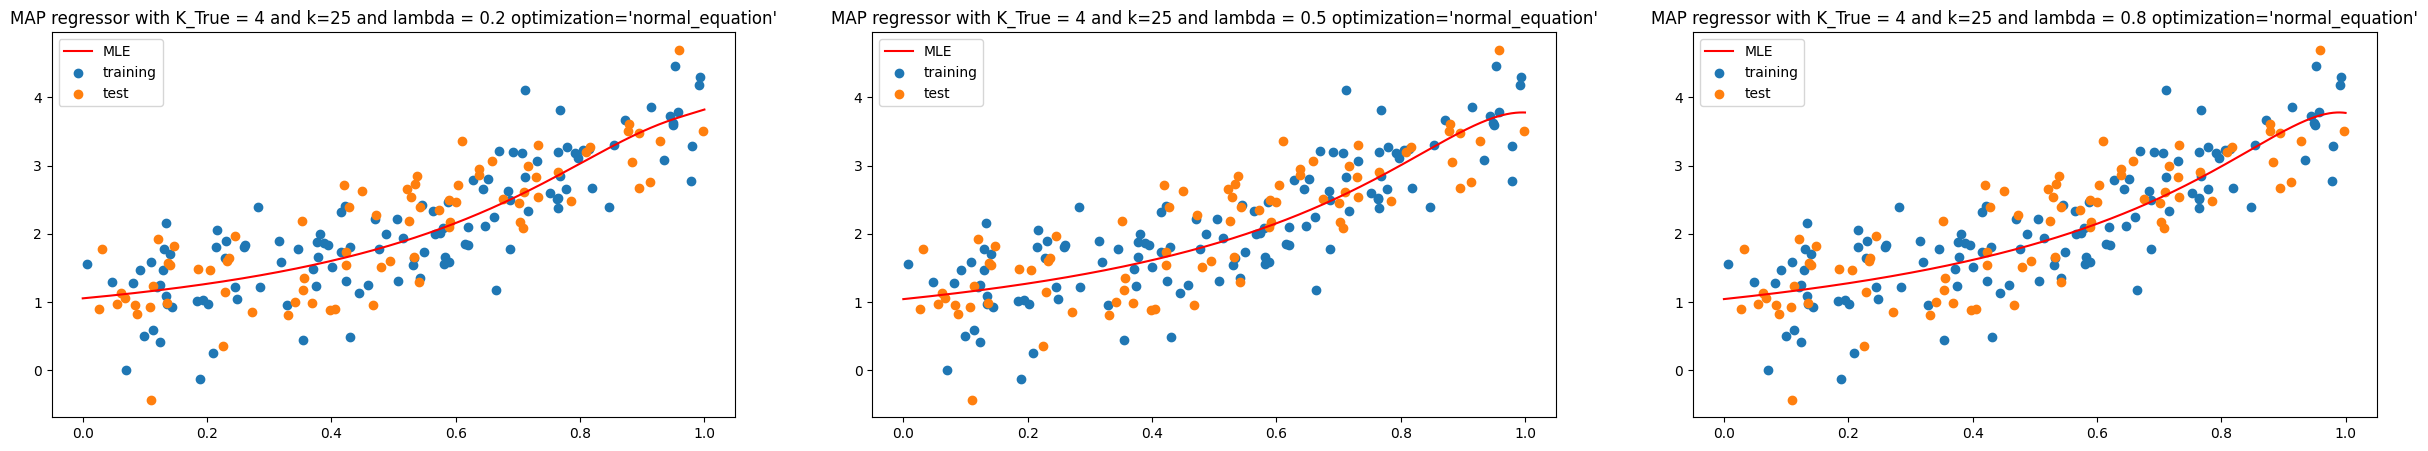

In [10]:
def test_map_regressor_and_plot(k, lambda_, ax, optimization="normal_equation"):
    theta_star = MAP(training_data=(Xtrain, Ytrain), K=k, lambda_=lambda_, optimization=optimization)

    regressor = polynomial_regressor(theta_star)
    visualize_regressor(regressor, (Xtrain, Ytrain), (Xtest, Ytest), k=k, title=f"MAP regressor with K_True = {K} and {k=} and lambda = {lambda_} {optimization=}", ax=ax)


def map_regressor_plot_for_different_k(ks, lambdas):
    for k in ks:
        fig = plt.figure(figsize=(30,5))
        for i, lambda_ in enumerate(lambdas):
            ax = fig.add_subplot(1,3,i+1)
            test_map_regressor_and_plot(k,lambda_, ax)


map_regressor_plot_for_different_k(ks=[2, 5, 10, 25], lambdas = [0.2, 0.5, 0.8])

In [11]:
def comparison_between_mle_map(K, lambdas, error_func, title):
    theta_mle = MLE((Xtrain, Ytrain), K, optimization="normal_equation")
    error_mle = error_func(theta_mle, (Xtest, Ytest))

    plt.figure(figsize=(5,5))
    plt.plot(error_mle, "x", label="MLE")

    errors_map = []
    for lambda_ in lambdas:
        theta_map = MAP((Xtrain, Ytrain), K, lambda_, optimization="normal_equation")
        error_map = error_func(theta_map, (Xtest, Ytest))

        errors_map.append(error_map)

    plt.plot(lambdas, errors_map, label=f"MAP")

    plt.ylabel("Error")
    plt.xlabel("Lambda")


    plt.title(title)

    plt.legend()

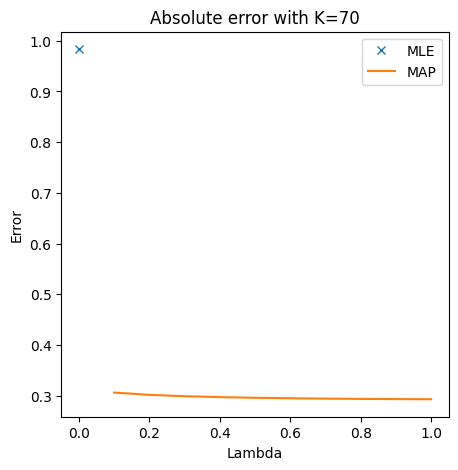

In [12]:
def comparison_between_mle_map_absolute_error(K, lambdas):
    comparison_between_mle_map(K, lambdas, error_func=average_absolute_error, title=f"Absolute error with {K=}")

comparison_between_mle_map_absolute_error(70, np.linspace(0.1,1,10))

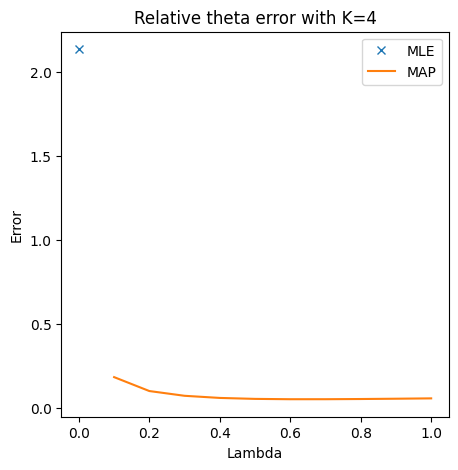

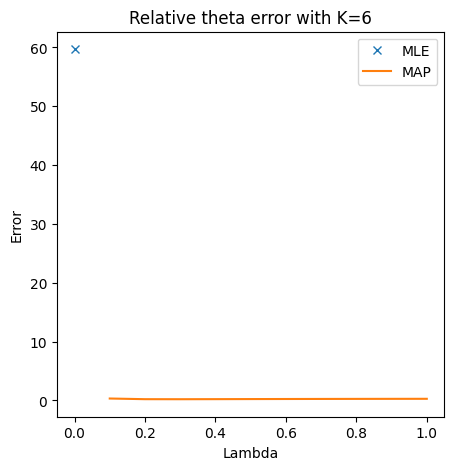

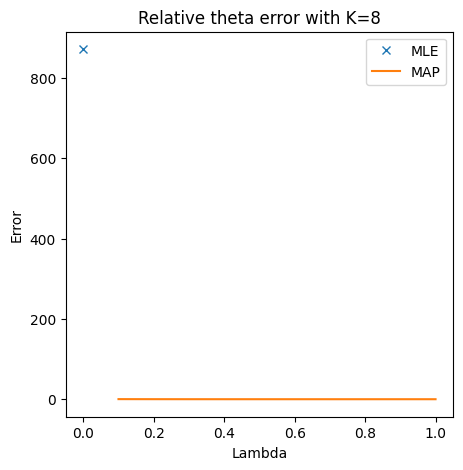

In [13]:
def relative_error_between_theta(theta, _):
    theta_true_padded = np.pad(theta_true, (0, len(theta) - len(theta_true)))
    return np.linalg.norm(theta - theta_true_padded) / np.linalg.norm(theta_true_padded)

def comparison_between_theta_true(ks, lambdas):
    for k in ks:
        comparison_between_mle_map(k, lambdas, error_func=relative_error_between_theta, title=f"Relative theta error with K={k}")

comparison_between_theta_true([4, 6, 8], np.linspace(0.1,1,10))

In [14]:
N = 1000
N_test = int(0.6 * N)

X, Y, theta_true = generate_test_problem_dataset(K, N=N, a=a, b=b, variance=variance)
Xtrain, Ytrain, Xtest, Ytest = shuffle_and_split_dataset(X, Y, N_test)


#mle_regressor_plot_for_different_k(ks=[2, 5, 10, 25])
#map_regressor_plot_for_different_k(ks=[2, 5, 10, 25], lambdas = [0.1, 0.5, 0.8])

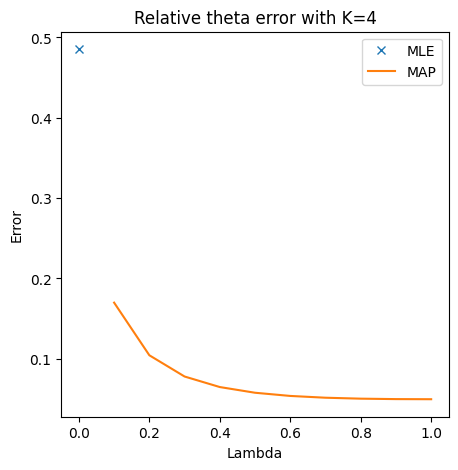

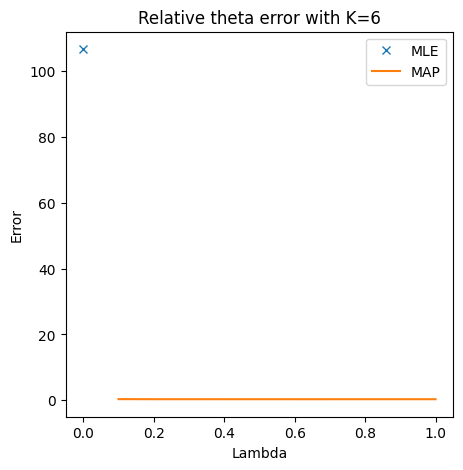

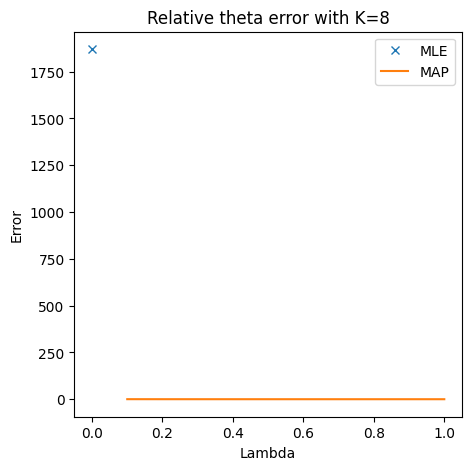

In [15]:
comparison_between_theta_true([4, 6, 8], np.linspace(0.1,1,10))

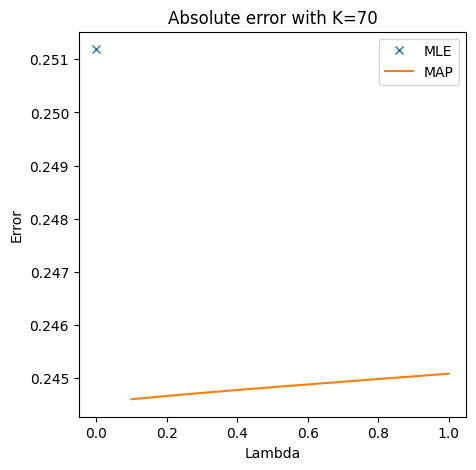

In [16]:
comparison_between_mle_map_absolute_error(70, np.linspace(0.1,1,10))

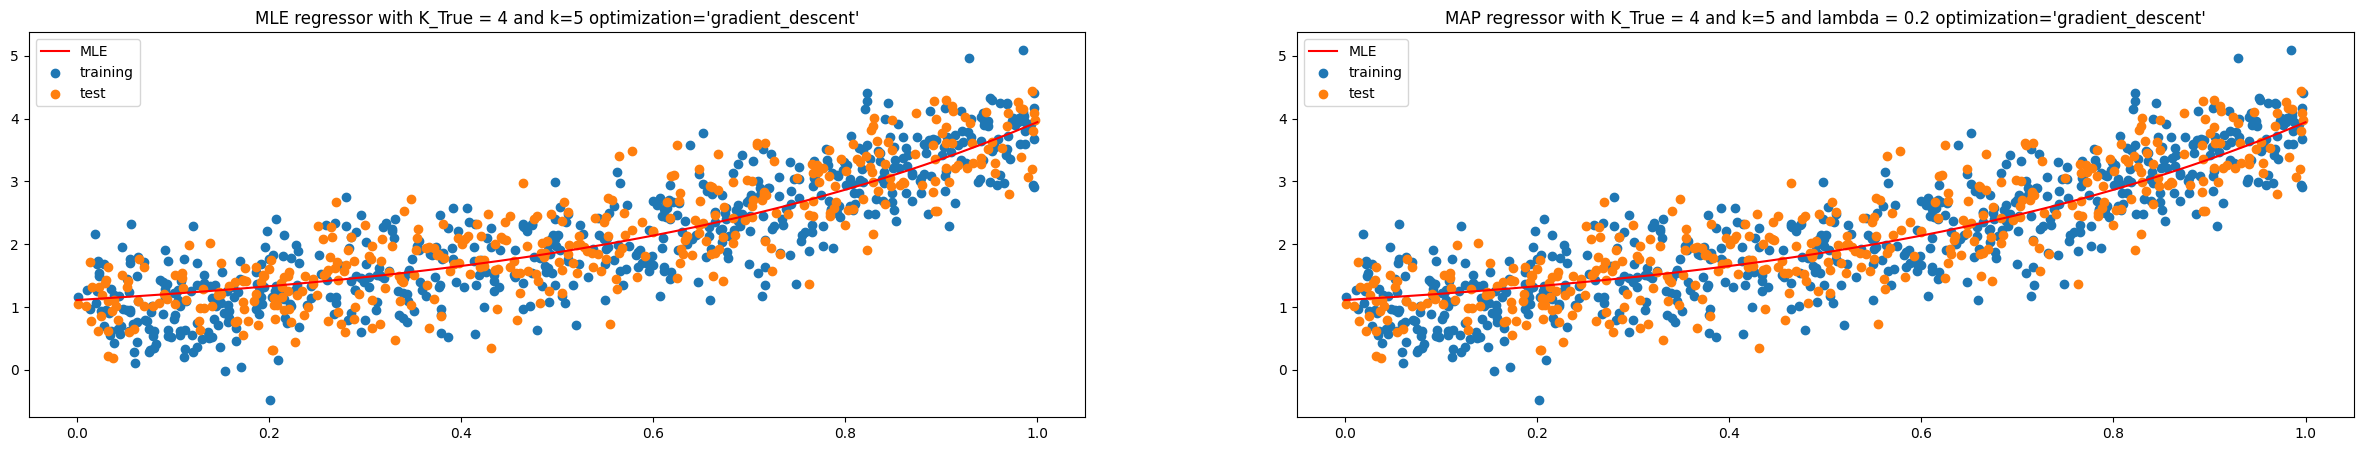

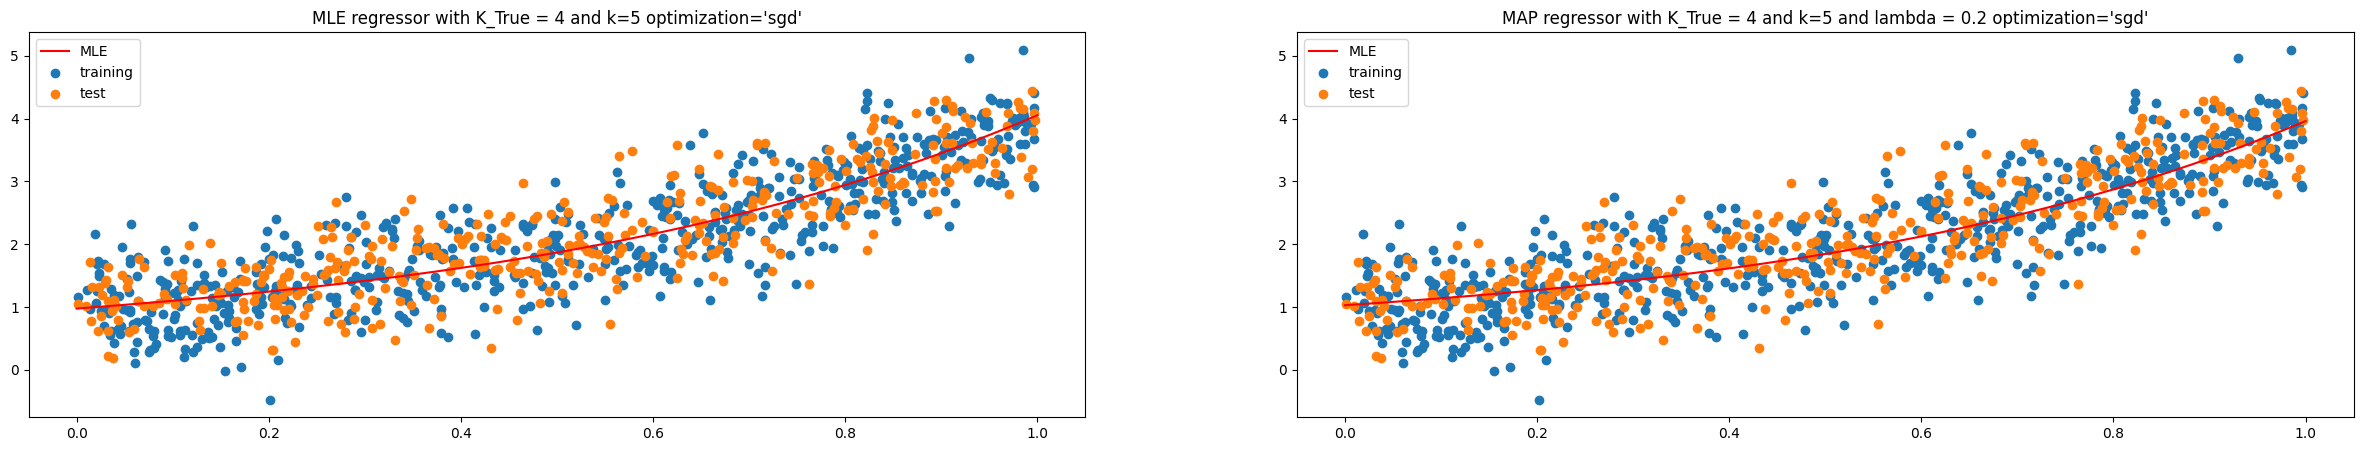

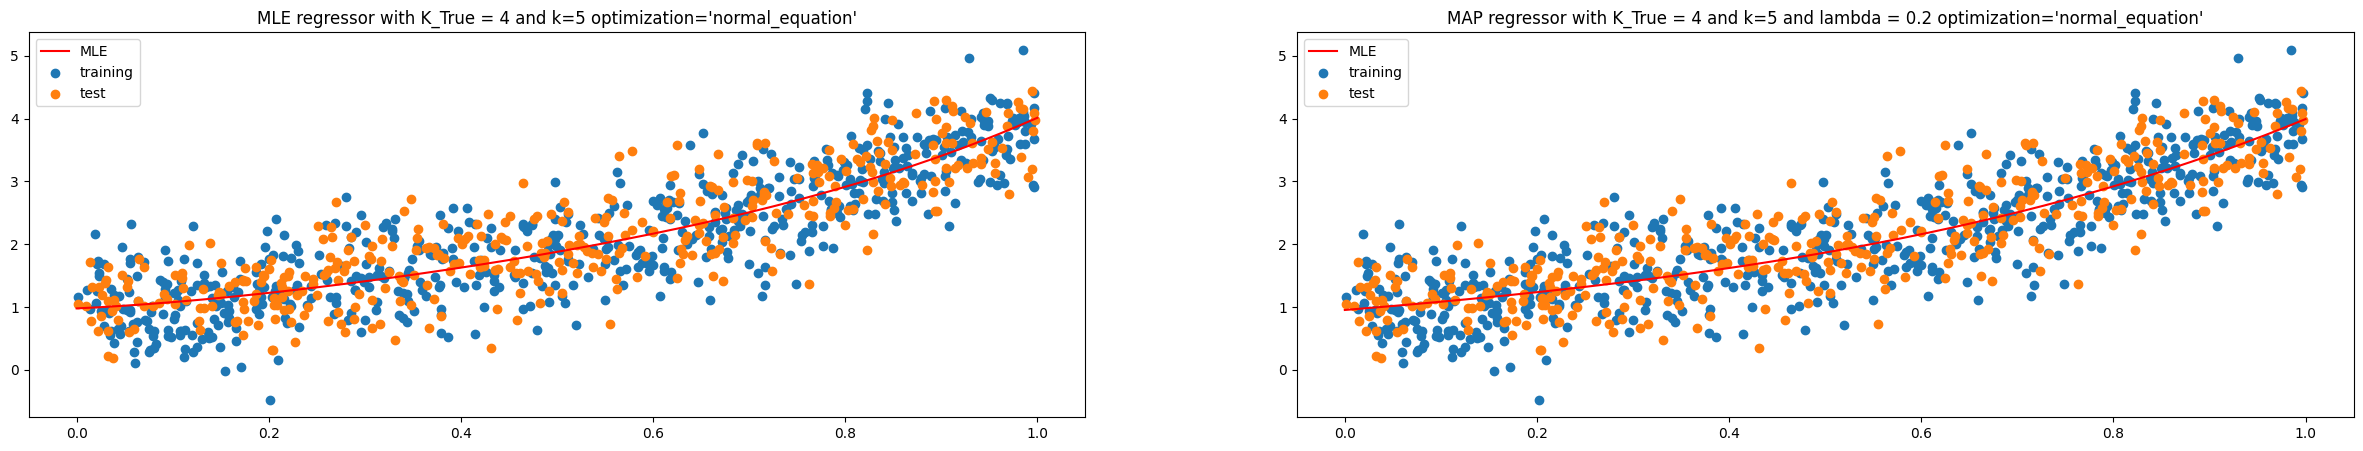

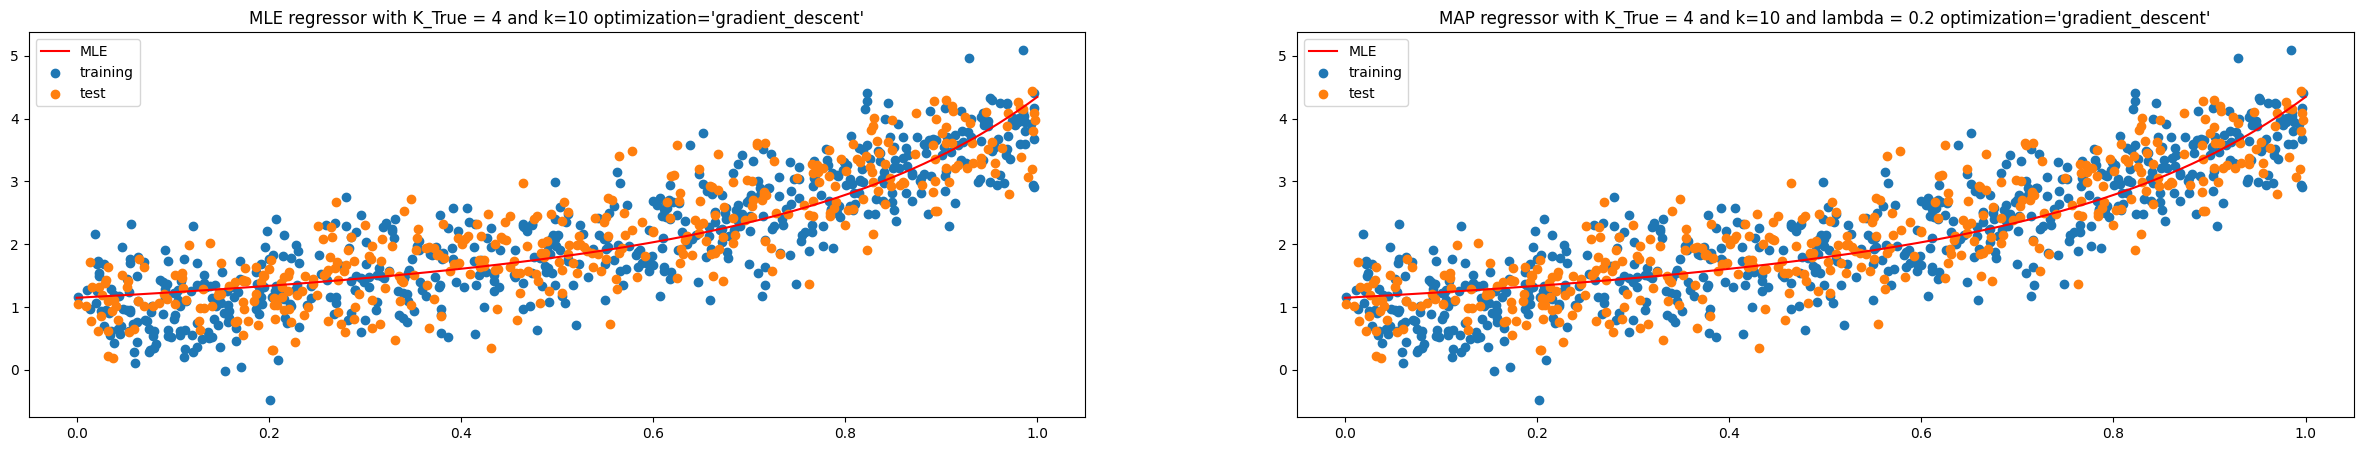

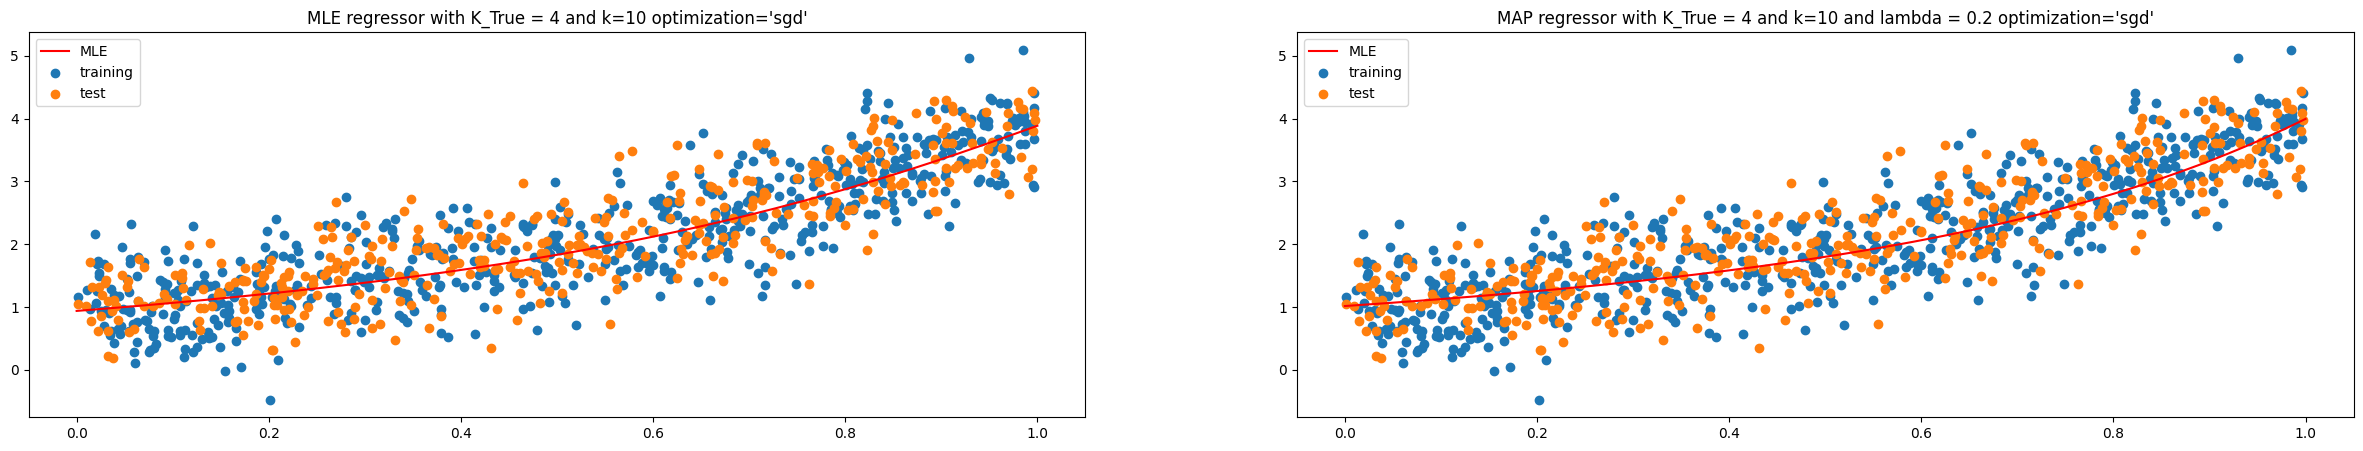

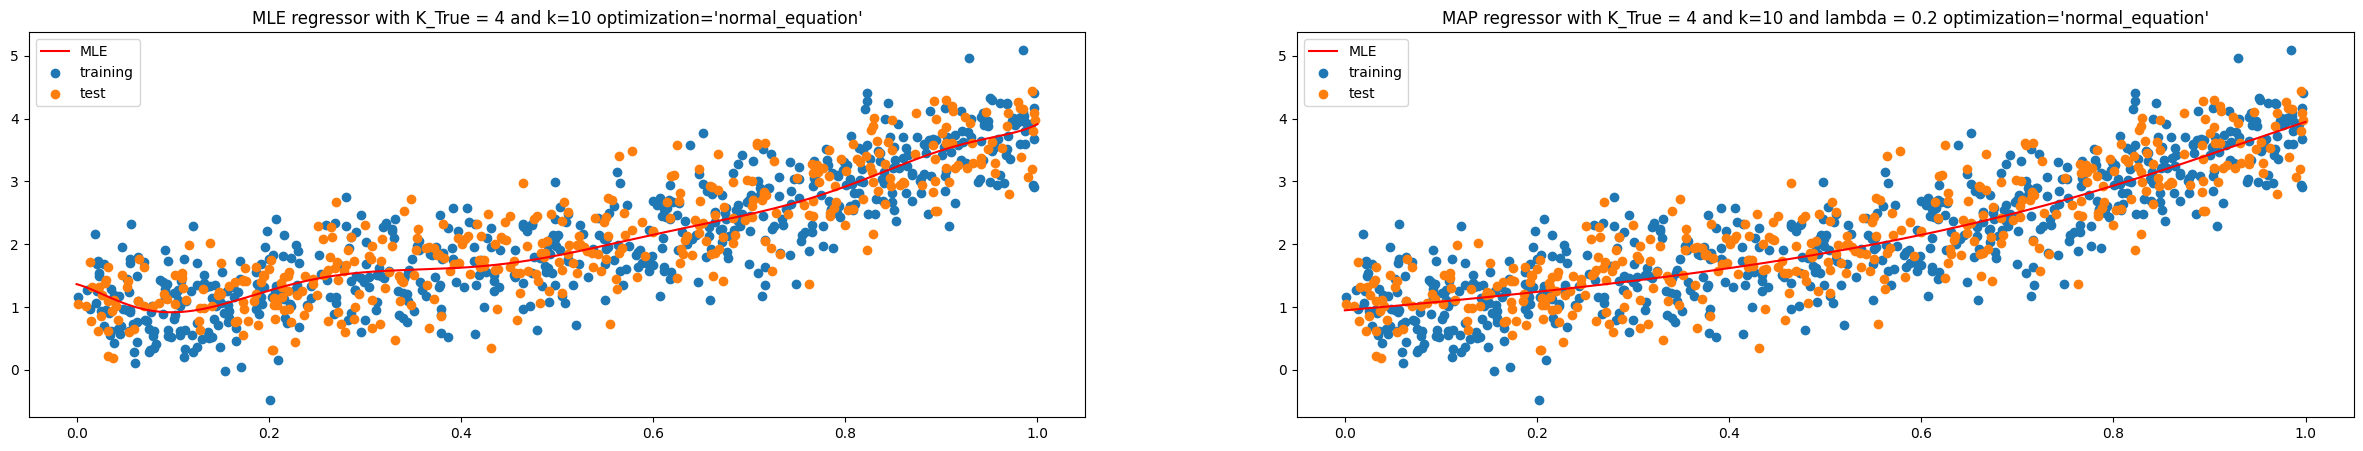

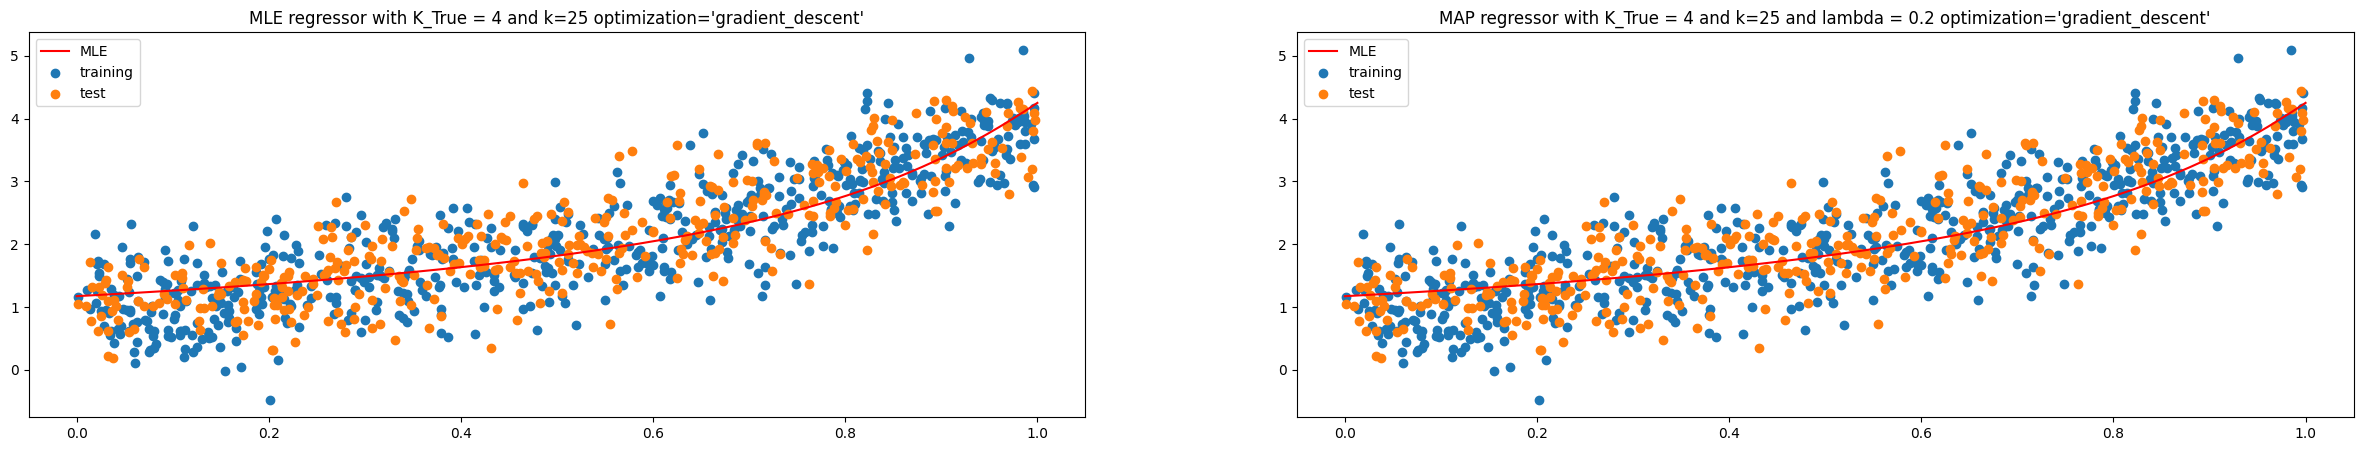

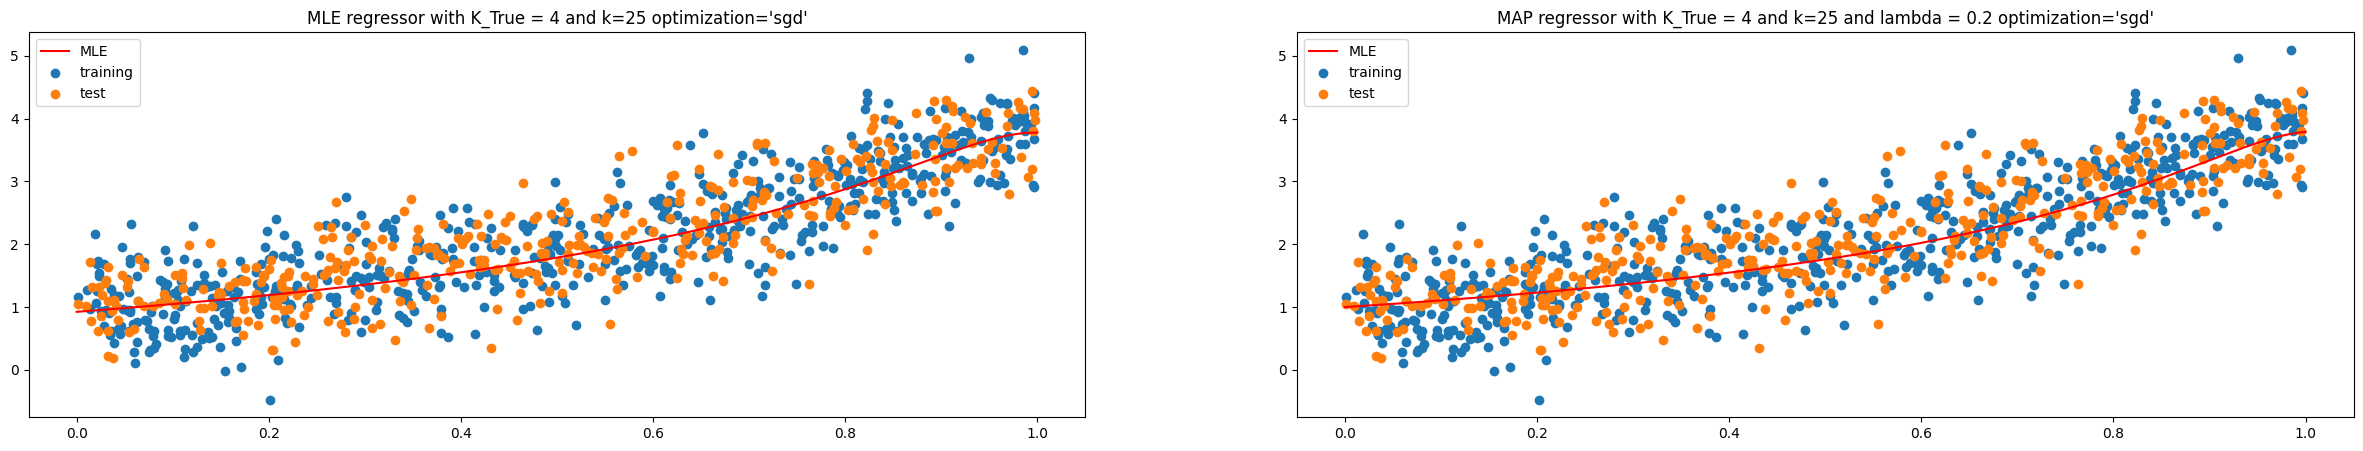

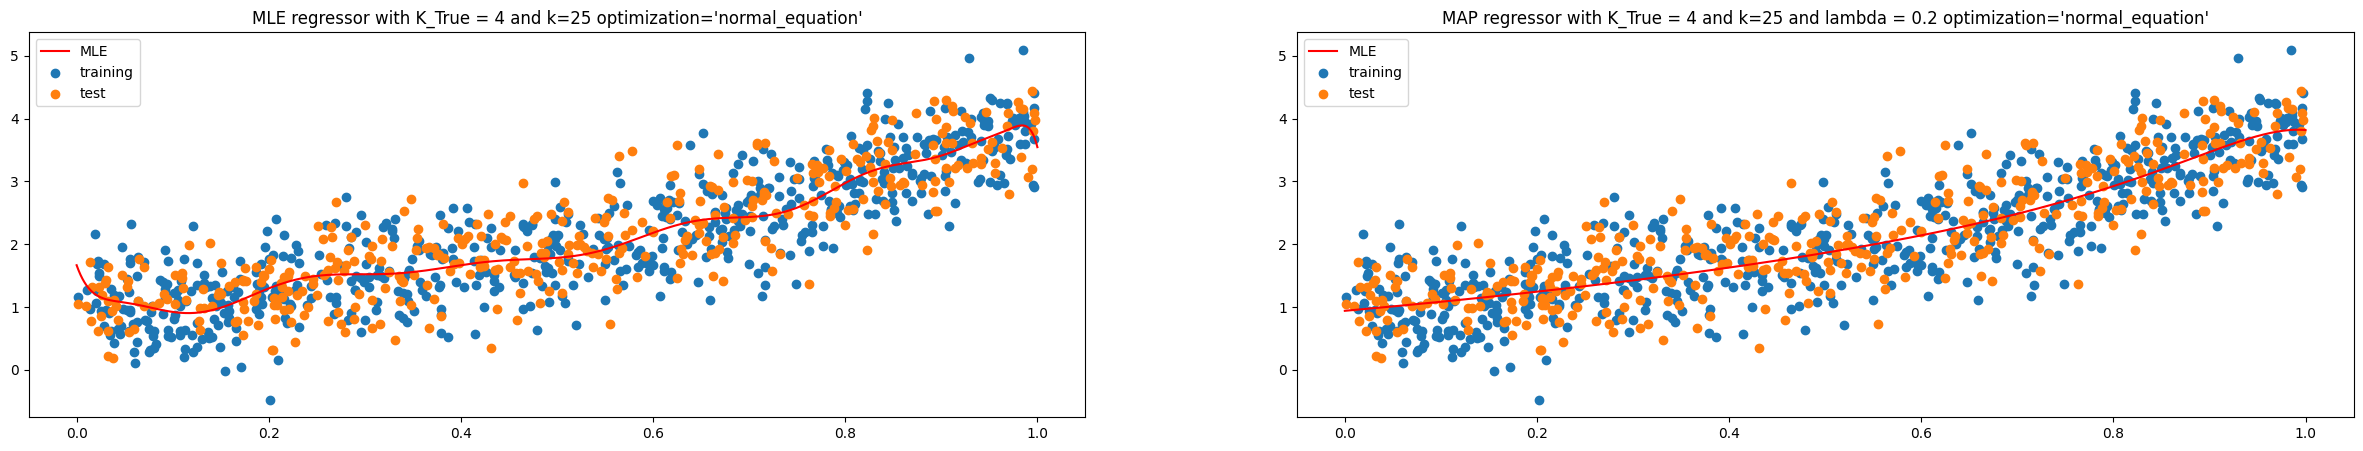

In [17]:
def comparison_between_gd_sgd_ne(ks):

    optimizations = ["gradient_descent", "sgd", "normal_equation"]
    lambda_ = 0.2
    for k in ks:
        for i, optimization in enumerate(optimizations):
            fig = plt.figure(figsize=(30,5))

            ax = fig.add_subplot(1,2,1)
            test_mle_regressor_and_plot(k, ax, optimization=optimization)

            ax = fig.add_subplot(1,2,2)
            test_map_regressor_and_plot(k,lambda_, ax, optimization=optimization)


comparison_between_gd_sgd_ne([5,10,25])